# HW Instructions

In this exercise, you will be working with the ViT model for image classification using the CIFAR10 dataset. 

The task will involve going through the full machine learning lifecycle, including: preprocessing and exploratory data analysis, model implementation and training, tuning, and evaluation. 

It is assumed that you have some prior experience in the field from previous assignments. This assignment allows for flexibility in exploring and implementing solutions as you see fit.
Make sure you read the instructions carefully.

In [1]:
# feel free to add any imports you might need (as long as it is part of the course environment)
import torch
import time
import copy
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder
from matplotlib import pyplot as plt
from collections import defaultdict

# Data Loading

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


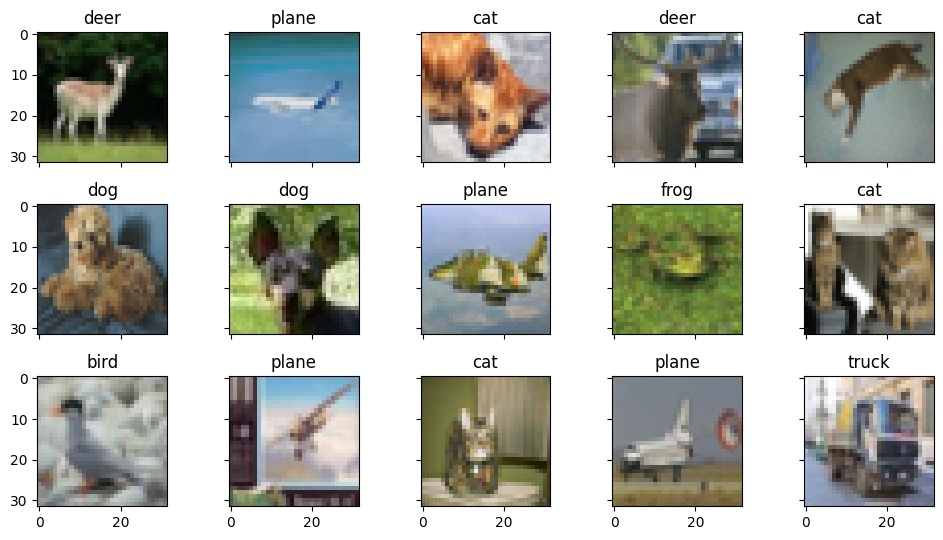

In [3]:
#############################################################################
# TO DO:                                                                    #
# plot a couple of images with their corresponding labels                   #
#############################################################################
samples_shape = (3,5)
fig, ax = plt.subplots(*samples_shape, sharey=True, sharex=True, figsize=(10,5.5))
idxes = np.random.randint(len(train_dataset), size=samples_shape)
for i in range(samples_shape[0]):
    for j in range(samples_shape[1]):
        idx = idxes[i,j]
        image, label = train_dataset.data[idx], train_dataset.targets[idx]
        ax[i,j].imshow(image)
        ax[i,j].set_title(classes[label])
plt.tight_layout()
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## A bit of exploratory data analysis (EDA)

In [4]:
#############################################################################
# TO DO:                                                                    #
# Figure out the size of the dataset:                                       #
# How many samples in train/test?                                            #
# How many labels? How many samples per label?                              #
# Try access train_dataset.__dict__.keys() to see which attributes          #
# are available on train_dataset.                                           #
#############################################################################

train_df = pd.DataFrame(train_dataset.targets, columns=['class_int'])
test_df = pd.DataFrame(test_dataset.targets, columns=['class_int'])
train_df['train_samples'] = train_df['class_int'].apply(lambda x: classes[x])
test_df['test_samples'] = test_df['class_int'].apply(lambda x: classes[x])

counts_df = pd.concat([train_df['train_samples'].value_counts(), test_df['test_samples'].value_counts()], axis=1)
counts_df.loc['total'] = counts_df.sum()
counts_df['total_samples'] = counts_df['train_samples'] + counts_df['test_samples']
counts_df.astype(int)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

,train_samples,test_samples,total_samples
frog,5000,1000,6000
truck,5000,1000,6000
deer,5000,1000,6000
car,5000,1000,6000
bird,5000,1000,6000
horse,5000,1000,6000
ship,5000,1000,6000
cat,5000,1000,6000
dog,5000,1000,6000
plane,5000,1000,6000


## Create DataLoaders

In [5]:
validation_split = 0.1

dataset_sizes = {'train': (1-validation_split) * len(train_dataset), 'val': validation_split * len(train_dataset)}
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)

split = int(np.floor(validation_split * len(train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [6]:
#############################################################################
# TO DO:                                                                    #
# Decide on a batch size (which later can be tunned)                        #
#############################################################################
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
validation_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'val': validation_loader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

# Building ViT Model

In the next section, you will construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

For this exercise, you will be required to implement the ViT model using a pre-built Encoder from the PyTorch library. Building the encoder can be challenging, so we have eliminated that step for you. If you are not familiar with the ViT model, it is highly recommended that you gain an understanding of its workings before beginning implementation. There is a ton of information available online, here is a pretty informative source:
https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline

In this assignment, you will be using a pre-built Encoder from the PyTorch library, which has already been loaded in the provided code. Therefore, you do not need to worry about the complexities of transformer computations when referring to the link provided.

In [7]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads, hidden_dim, 
                 mlp_dim, dropout, attention_dropout):
        super().__init__()
        
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the required layers for your ViT model implementation.           #
        # Hint: For the curious among us, you can pick at pytorch's                 #
        # official implemetantion of vit (vit_b_16).                                #
        #############################################################################
        self.seq_length = (image_size // patch_size) ** 2
        flat_size = hidden_dim * self.seq_length
        
        # initializing the encoder backbone
        # you should calculate the seq_length
        self.encoder = Encoder(
        seq_length=self.seq_length,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        attention_dropout=attention_dropout
        )

        self.mapper = nn.Linear(3*patch_size**2, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(flat_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim, momentum=0.01),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        

        #############################################################################
        # TO DO:                                                                    #
        # Complete the rest of the class (foward method and other helper            #
        # functions if needed).                                                     #
        #############################################################################
    def forward(self, x: torch.Tensor):
        x = x.reshape(x.shape[0], self.seq_length, -1)
        x = self.mapper(x)
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [8]:
# this is just a simple initialization, feel free to change it.
model = ViT(image_size=32, patch_size=8, num_classes=10, num_layers=2, num_heads=2, hidden_dim=128, 
                 mlp_dim=256, dropout=0.15, attention_dropout=0.15)

# Training

## IMPORTANT READ!

In the following section, you will be required to train your implementation of the ViT model as in previous assignments. However, it is important to note that training transformers can be challenging, especially when starting from scratch, as is the case in this exercise.

It is acceptable if your final model does not achieve a high accuracy score, but it is crucial to document your training experiments and demonstrate that the model is able to train correctly (i.e. the loss decreases over time). This includes noting what you tried, what parameters worked best, and providing the loss and accuracy graphs as instructed in the next sections.

A reference for training ViT on CIFAR10 can be found at https://github.com/omihub777/ViT-CIFAR. However, it's important to note that in the provided reference, the ViT model was trained using 200 epochs and over 2 hours of training.

Note 1: If the loss decreases and your model trains correctly, you are on the safe side. The focus should be on the experiments and the things you tried.

Note 2: The main goal is not to achieve a high accuracy score but to demonstrate that you understand the process.

Note 3: If your final model's performance is strictly better than a random model (accuracy of around 1/num_classes) and you have provided thorough documentation of your experiments and processes, you will receive full credit for the assignment. 

In [9]:
#############################################################################
# TO DO:                                                                    #
# Create a validation set from the training set
# Implement the training loop
# Save the loss and accuracy for both training/validation sets every couple of iterations for plotting afterwards.
#############################################################################

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################




In [10]:
def train_model(model, criterion, optimizer: optim.Optimizer, scheduler=None, num_epochs=5):
    train_history = defaultdict(list)
    val_history = defaultdict(list)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                images, labels = sample

                optimizer.zero_grad()

                output = model(images)
                loss = criterion(output, labels)

                running_loss += loss.item()
                y_pred = torch.max(output, dim=1)[1]
                running_corrects += (y_pred == labels).sum()

                if model.training:
                    loss.backward()
                    optimizer.step()
                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            history = train_history if model.training else val_history
            history['loss'].append(epoch_loss)
            history['accuracy'].append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_history, val_history

In [11]:
lr = 9e-3
num_epochs = 5

optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()

In [12]:
best_model, train_history, val_history = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/5
----------
train Loss: 0.0129  |  Acc: 0.4116
val Loss: 0.0119  |  Acc: 0.4744
Epoch 2/5
----------
train Loss: 0.0110  |  Acc: 0.4943
val Loss: 0.0108  |  Acc: 0.5198
Epoch 3/5
----------
train Loss: 0.0103  |  Acc: 0.5299
val Loss: 0.0105  |  Acc: 0.5316
Epoch 4/5
----------
train Loss: 0.0097  |  Acc: 0.5548
val Loss: 0.0102  |  Acc: 0.5474
Epoch 5/5
----------
train Loss: 0.0093  |  Acc: 0.5780
val Loss: 0.0095  |  Acc: 0.5792
Training complete in 3m 25s
Best val Acc: 0.579200


## Loss and Acurracy

In [13]:
# Plot 2 graphs:
# Graph 1: Loss vs itreation for training and validation sets
# Graph 2: Accuracy vs itreation for training and validation sets

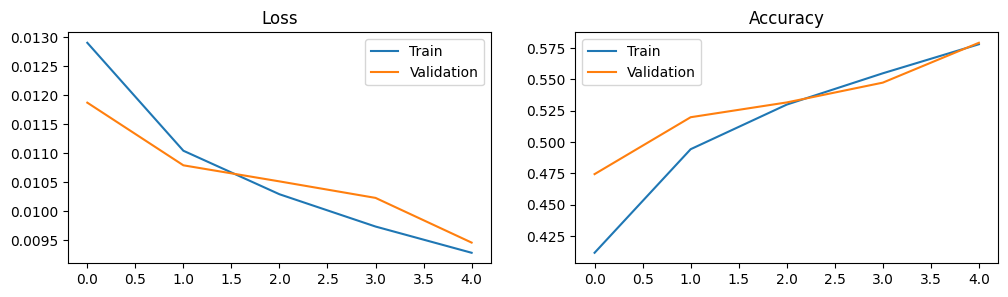

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,3))
for i, metric in enumerate(train_history.keys()):
    ax[i].plot(range(num_epochs), train_history[metric], label='Train')
    ax[i].plot(range(num_epochs), val_history[metric], label='Validation')
    ax[i].set_title(metric.capitalize())
    ax[i].legend()

# Evaluation 

In [15]:
# Calculate the accuracy of the final model on the test set.

In [16]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
total = 0
correct = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        # calculate outputs by running images through the network
        outputs = model.forward(images)

        # the class with the highest energy is what we choose as prediction
        _, predictions = outputs.max(1)
        total += labels.size(0)
        correct += (labels == predictions).sum()
        for i in range(len(labels)):
            confusion_matrix[labels[i], predictions[i]] += 1

model_accuracy = 100 * (correct / total)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(test_dataset), model_accuracy))

Model accuracy on 10000 test images: 57.34%


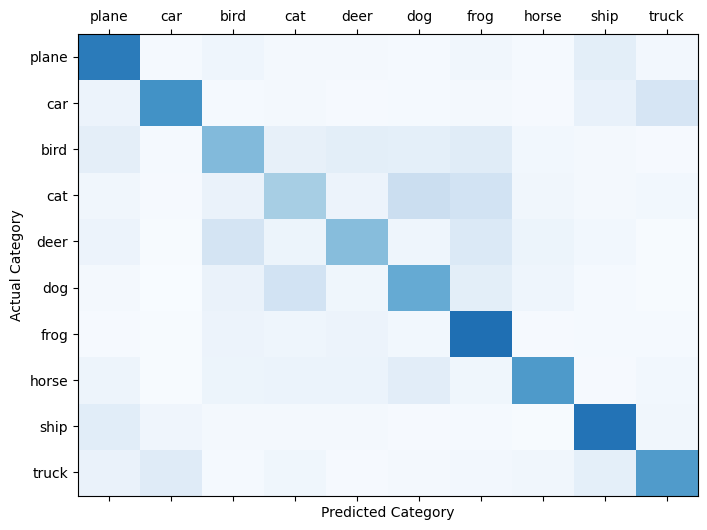

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

# Questions

##**Question:** 

Explain the importance of the positional embedding in the ViT model.

**Your answer:** *When inferring the picture, it's important to know the position of each patch in the image in order to re-assemble it, and also for the transformer to consider the image structure.*

##**Question:** 

How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?

**Your answer:** *We can use SMOTE (Synthetic Minority Oversampling Technique) oversampling. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.*